In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/'

Obtain the UVB grid from FG20

In [4]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [5]:
z_test = 1

In [6]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [7]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [8]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [9]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [10]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [11]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [12]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):

    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

Enter measurements for species

In [13]:
logN_dict = {'HI':'15.40, -0.06, +0.06',
            'CII':'<13.46',
            'CIII':'13.97, -0.03, +0.03',
            'CIV':'13.73, -0.05, +0.05',
            'NII':'<13.23',
            'NIII':'<13.42',
            'NV':'<13.72',
            'OII':'<13.29',
            'OIII':'14.42, -0.02, +0.02',
            'OIV':'14.95, -0.03, +0.03',
            'NeVIII':'<13.35',
            'MgII':'<11.52',
            'AlIII':'<12.29',
            'SiII':'<13.27',
            'SiIII':'<12.77',
            'SVI':'<12.79',
            'FeII':'<11.90'}

Sort ions by ionization potential

In [14]:
# Order ions by ionization potential
ions_ordered = [s for s in list(IP_dict.keys()) if s in list(logN_dict.keys())]

Obtain CLOUDY grids at the HI column density of this absorber

In [15]:
logN_HI_test = np.array(logN_dict['HI'].split(','), dtype=float)[0]

Define a function to go from $[\alpha/H], [X/\alpha]$ to $[M/H]$

In [16]:
# Solar fractional densities
relative_dens_solar = {'alpha': 0.000682705,
                     'Helium': 0.1,
                     'Carbon': 0.000245,
                     'Nitrogen': 8.51e-05,
                     'Iron': 2.82e-05,
                     'others': 8.4525633e-06}

In [17]:
def get_log_metals(alpha_H, C_alpha, N_alpha, Fe_alpha):
    
    # First generate the relative density of alpha to H
    # Remember [alpha/H] is on a log scale
    n_alpha_H = relative_dens_solar['alpha']*10**alpha_H
    
    # Next, generate the non-alpha elements
    # The first term computes C/alpha in solar (since both numerator and denominator are solar, relative to H)
    # Then, it scales solar C/alpha as necessary
    n_C_alpha = (relative_dens_solar['Carbon']/relative_dens_solar['alpha'])*10**C_alpha
    # Now that we have the necessary C/alpha, we multiply by alpha/H to get C/H
    n_C_H = n_C_alpha*n_alpha_H
    
    # Repeat for other non-alpha elements
    # Nitrogen
    n_N_alpha = (relative_dens_solar['Nitrogen']/relative_dens_solar['alpha'])*10**N_alpha
    n_N_H = n_N_alpha*n_alpha_H
    
    # Iron
    n_Fe_alpha = (relative_dens_solar['Iron']/relative_dens_solar['alpha'])*10**Fe_alpha
    n_Fe_H = n_Fe_alpha*n_alpha_H
    
    # Finally, the solar abundance metals
    n_other_H = relative_dens_solar['others']
    
    # Add up all relative densities together for all metals
    # Alpha + not-alpha + solar pattern metals
    n_M_H = n_alpha_H + n_C_H + n_N_H + n_Fe_H + n_other_H
    # Get the solar value
    n_M_H_solar = relative_dens_solar['alpha']+relative_dens_solar['Carbon']+relative_dens_solar['Nitrogen']+relative_dens_solar['Iron']+relative_dens_solar['others']
    
    # Finally, generate the metal abundance
    return np.log10(n_M_H/n_M_H_solar)

Make some diagnostic plots to understand the effects of $[\alpha/H], [X/H]$ on metallicity

In [18]:
alpha_H_range = np.arange(-5, 1.1, 0.1, dtype=float)
C_alpha_range = np.arange(-3, 2, 1, dtype=float)

In [19]:
M_H_baseline = np.log10(relative_dens_solar['others']/(relative_dens_solar['others']+relative_dens_solar['alpha']+relative_dens_solar['Carbon']+relative_dens_solar['Nitrogen']+relative_dens_solar['Iron']))

Text(0, 0.5, '$[\\mathrm{M}/\\mathrm{H}]$')

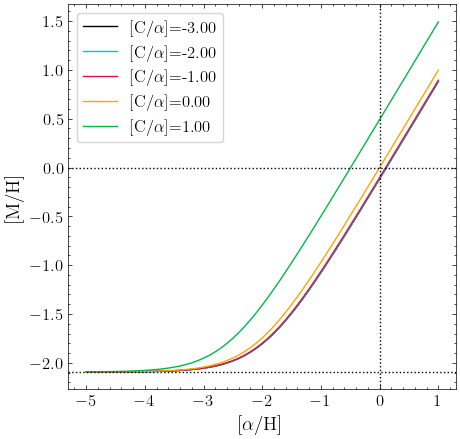

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)

for C_alpha in C_alpha_range:
    ax.plot(alpha_H_range, [get_log_metals(alpha_H, C_alpha, 0, 0) for alpha_H in alpha_H_range],
           label=r'$[\mathrm{C}/\alpha]$='+'{:.2f}'.format(C_alpha))

ax.axvline(0, linestyle=':')
ax.axhline(0, linestyle=':')
ax.axhline(M_H_baseline, linestyle=':')
    
ax.legend()
ax.set_xlabel(r'$[\alpha/\mathrm{H}]$')
ax.set_ylabel(r'$[\mathrm{M}/\mathrm{H}]$')

Get a low and high density phase of the CLOUDY models to overplot on column densities

In [21]:
log_hdens_test = -3.3
alpha_H_test = -0.6
C_alpha_test = -0.5
log_metals_test = get_log_metals(alpha_H_test, C_alpha_test, 0, 0) #-0.6

logN_species_test = []

# Respect ordering of ions
for i in range(1,len(ions_ordered)):
        
    ion = ions_ordered[i]   
    s = ion_species_dict[ion]
    logN_s = species_logN_interp[s]([logN_HI_test, log_hdens_test, log_metals_test])[0]
    
    if '+' in s:
        
        if s.split('+')[0] == 'C':
            logN_s += C_alpha_test

    # Get interpolated column density from CLOUDY grid
    logN_species_test.append(logN_s)

Make the plot of VP fit column densities and overplot CLOUDY predictions

[]

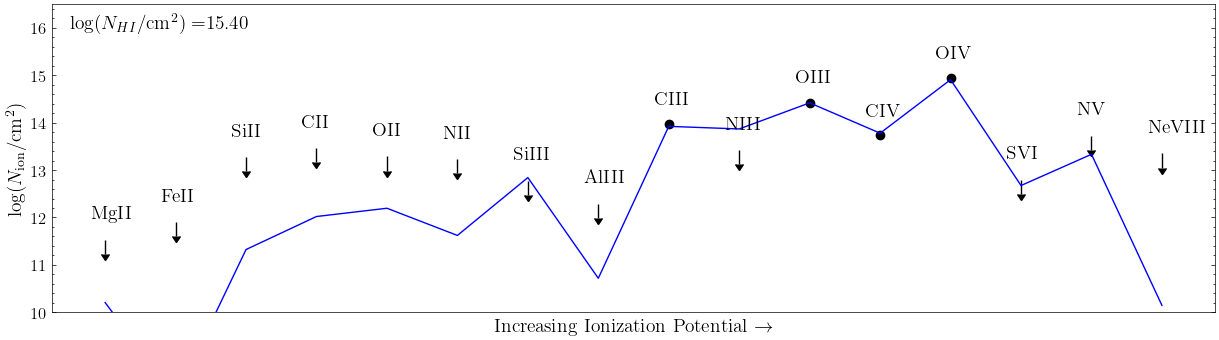

In [22]:
fig, ax = plt.subplots(1, figsize=(15,4))

for i in range(1, len(ions_ordered)):
    
    ion = ions_ordered[i]
    
    logN_str = logN_dict[ion]
    
    # Detection
    if logN_str[0] != '<' and logN_str[0] != '>':
        logN_arr = np.array(logN_str.split(','), dtype=float)
        ax.scatter(i, logN_arr[0], color='black')
        ax.errorbar(x=i, y=logN_arr[0], yerr=logN_arr[1], color='black')
        ax.text(x=i-.2, y=logN_arr[0]+logN_arr[1]+.45, s=ion)
    
    # Upper limit
    elif logN_str[0] == '<':
        logN_lim = float(logN_str[1:])
        ax.errorbar(x=i, y=logN_lim, yerr=0.3, uplims=True, color='black')
        ax.text(x=i-.2, y=logN_lim+0.3+.15, s=ion)
        
    
    # Lower limit
    # Not implemented yet
    elif logN_str[0] == '>':
        pass
    
ax.plot(np.arange(1,len(logN_species_test)+1,1), logN_species_test, color='blue')

ax.set_ylim(10,16.5)
ax.text(x=0.5, y=16, s=r'$\log (N_{HI}/ \mathrm{cm}^2) = $' + '{:.2f}'.format(logN_HI_test))
ax.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^2)$')
ax.set_xlabel(r'Increasing Ionization Potential $\rightarrow$')
ax.set_xticks([])
ax.set_xticks([], minor=True)

Define prior, likelihood, and probability functions

In [23]:
def log_prior(params):
    
    # Grid parameters being varied
    log_hdens, alpha_H, C_alpha = params
    log_metals = get_log_metals(alpha_H, C_alpha, 0, 0)
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    
    # Fun :D
    if log_hdens_min < log_hdens < log_hdens_max:
        if log_metals_min < log_metals < log_metals_max:
            return 0.0
        return -np.inf
    return -np.inf

In [24]:
def log_likelihood(params, logN_HI, logN_dict, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens, alpha_H, C_alpha = params
    log_metals = get_log_metals(alpha_H, C_alpha, 0, 0)
    
    # Likelihood function
    ll = 0
    
    ions = list(logN_dict.keys())
    
    # Ignore first entry since it's HI
    for i in range(1,len(ions)):
        
        # This is from VP fit
        ion = ions[i]
        logN_str = logN_dict[ion]
        
        # This is from CLOUDY
        s = ion_species_dict[ion]
        
        # Get interpolated column density from CLOUDY grid
        y_bar = species_logN_interp[s]([logN_HI, log_hdens, log_metals])[0]
        
        # Shift CLOUDY predicted column density in case of C, N, Fe
        if '+' in s:

            if s.split('+')[0] == 'C':
                y_bar += C_alpha
        
        # Based on detection or non-detection, compute the likelihood term
        
        # Detection
        if logN_str[0] != '<' and logN_str[0] != '>':
            
            logN_arr = np.array(logN_str.split(','), dtype=float)
            
            # Observed column density
            y = logN_arr[0]
            # Use max of lower and upper error for defining Gaussian distribution of column density
            sig_y = max(-logN_arr[1], logN_arr[2])
            # Gaussian likelihood
            ll += -.5*(y-y_bar)**2/sig_y**2

        # Upper limit
        elif logN_str[0] == '<':
            
            # Upper limit of column density
            # This is 3-sigma
            y = float(logN_str[1:])
            
            # Uncertainty in column density
            # This is 1-sigma
            sig_y = y-np.log10(3)
            
            # Define an integration range for the reported value, from "-inf" to upper limit
            # Use a step size of 0.1 dex
            y_range = np.arange(-10, y+0.05, 0.05)
            
            # Confusing notation :(
            # CDF
            ll += np.log(integrate.simpson(x=y_range, y=np.exp(-.5*(y_range-y_bar)**2/sig_y**2)))
            
        # Lower limit
        # Not implemented yet
        elif logN_str[0] == '>':
            pass      
        
    # Return log likelihood for MCMC
    return ll

In [25]:
def log_probability(params, logN_HI, logN_dict, species_logN_interp):
    
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, logN_HI, logN_dict, species_logN_interp)

Ready to fit all elements :)

In [27]:
pos = np.array([log_hdens_test,alpha_H_test,C_alpha_test])+1e-4*np.random.randn(500,3)
nwalkers, ndim = pos.shape

In [28]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_HI_test, logN_dict, species_logN_interp)
)

In [29]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [16:03<00:00,  1.93s/it]


In [30]:
samples = sampler.get_chain()
np.save(file='z_0_67532_non_solar_samples', arr=sampler.get_chain())

#samples = np.load('z_0_67532_non_solar_samples.npy')

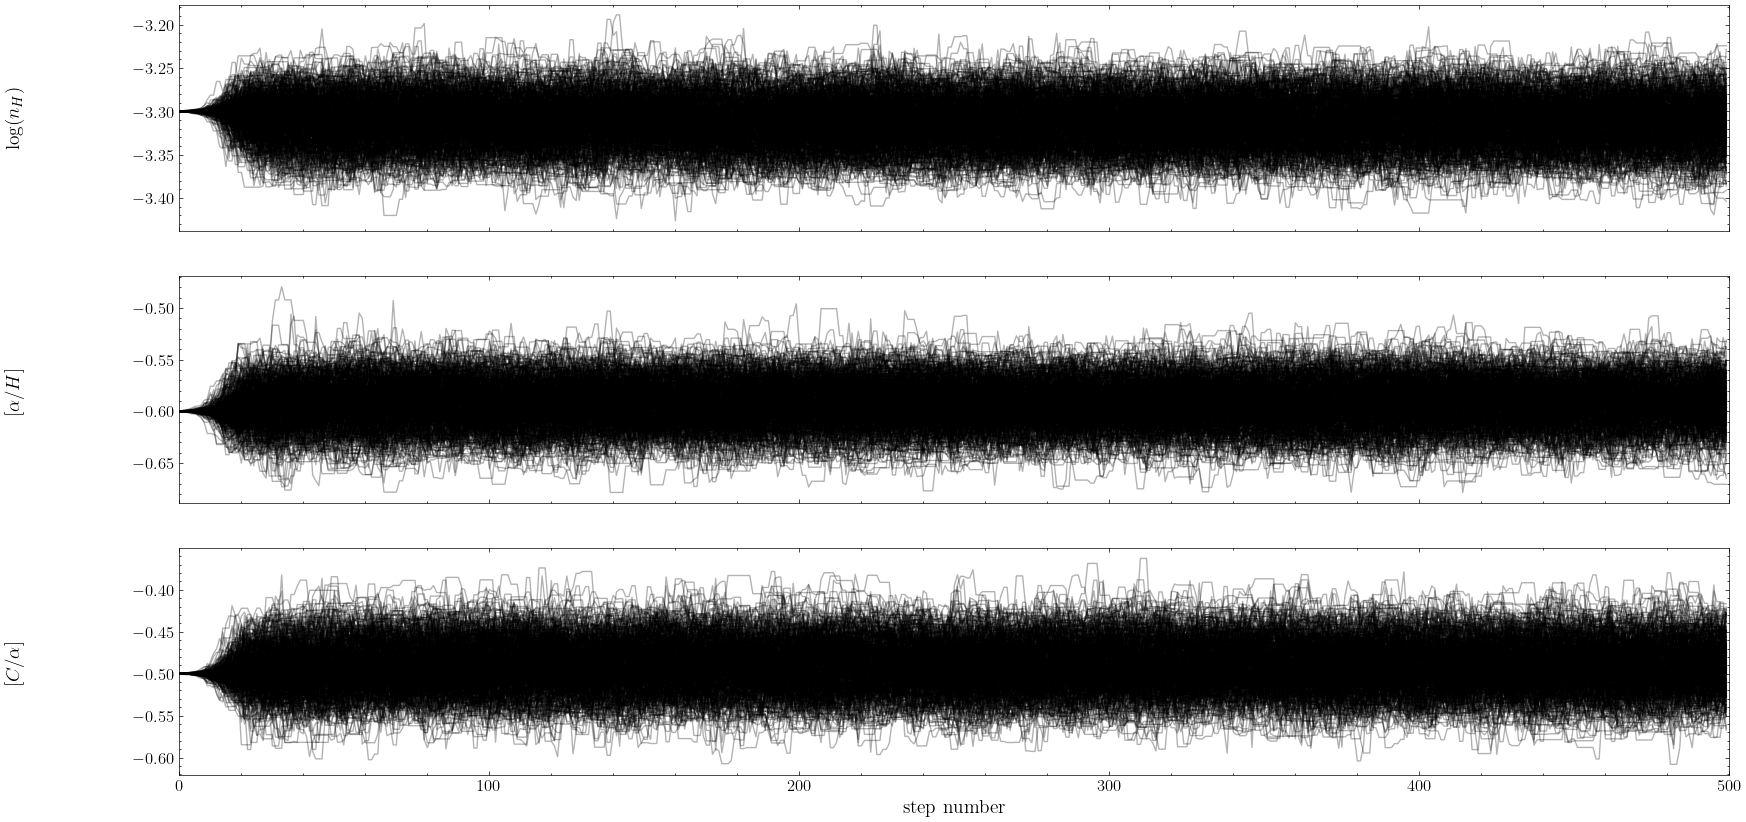

In [31]:
fig, axes = plt.subplots(3, figsize=(20, 10), sharex=True)
samples = sampler.get_chain()
labels = [r'$\log(n_H)$', r'$[\alpha/H]$', r'$[C/\alpha]$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [33]:
flat_samples = sampler.get_chain(discard=100, flat=True)

In [34]:
np.save(file='z_0_67532_non_solar_flat', arr=flat_samples)
#flat_samples = np.load(file='z_0_67532_non_solar_flat.npy')

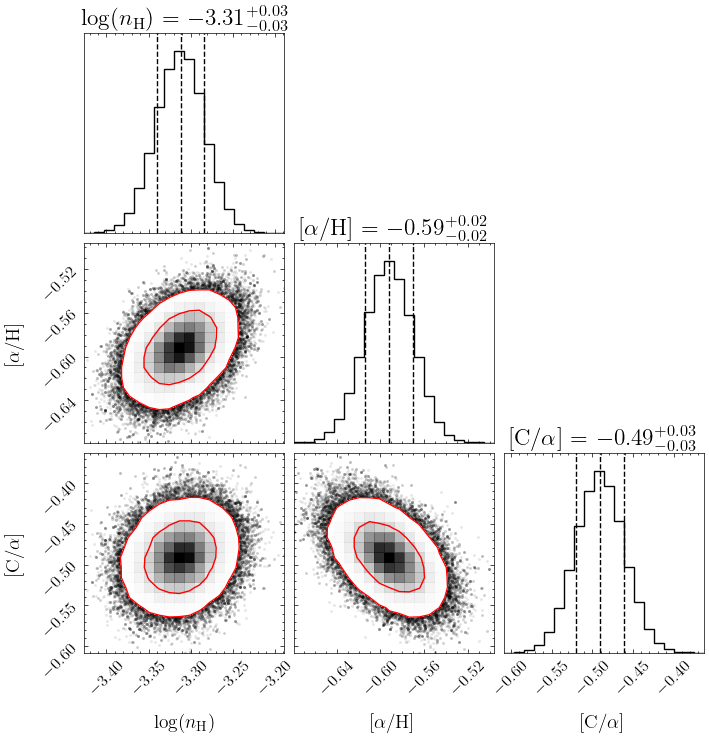

In [35]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels = [r'$\log(n_\mathrm{H})$', r'$[\alpha/\mathrm{H}]$', r'$[\mathrm{C}/\alpha]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Plot samples on top of column densities

In [36]:
sample_indices = np.random.randint(low=0, high=len(flat_samples), size=100)

[]

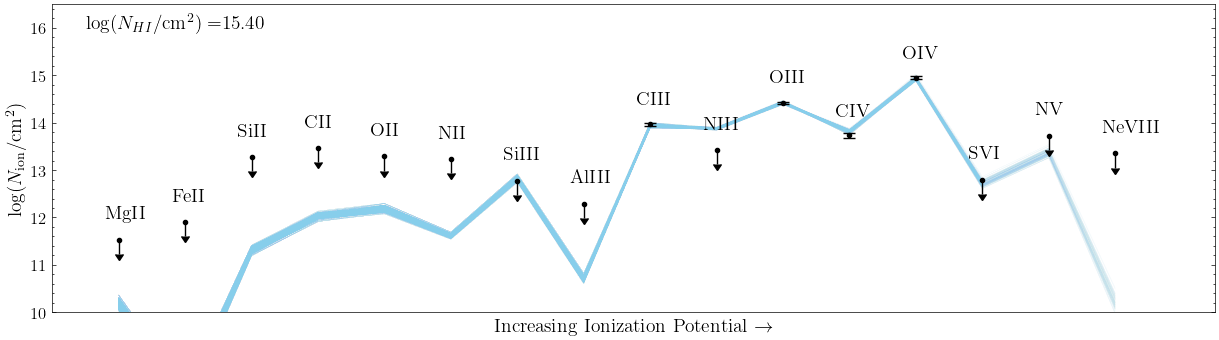

In [37]:
fig, ax = plt.subplots(1, figsize=(15,4))

for i in range(len(sample_indices)):
    
    idx = sample_indices[i]
    log_hdens, alpha_H, C_alpha = flat_samples[idx]
    log_metals = get_log_metals(alpha_H, C_alpha, 0, 0)
    
    logN_species_test = []

    for i in range(1,len(ions_ordered)):

        ion = ions_ordered[i] 
        s = ion_species_dict[ion]
        logN_s = species_logN_interp[s]([logN_HI_test, log_hdens, log_metals])[0]
        
        if '+' in s:

            if s.split('+')[0] == 'C':
                logN_s += C_alpha

        # Get interpolated column density from CLOUDY grid
        logN_species_test.append(logN_s)
        
        # Plot
        ax.plot(np.arange(1,len(logN_species_test)+1,1), logN_species_test, color='skyblue', lw=.2, alpha=.1)

for i in range(1, len(ions_ordered)):
    
    ion = ions_ordered[i]
    
    c = 'black'
    
    logN_str = logN_dict[ion]
    
    # Detection
    if logN_str[0] != '<' and logN_str[0] != '>':
        
        logN_arr = np.array(logN_str.split(','), dtype=float)
        
        ax.scatter(i, logN_arr[0], color=c, s=3)
        ax.errorbar(x=i, y=logN_arr[0], yerr=logN_arr[1], color=c, linestyle='None',
                    fmt='o', markersize=3, capsize=4)
        ax.text(x=i-.2, y=logN_arr[0]+logN_arr[1]+.45, s=ion, color=c)
    
    # Upper limit
    elif logN_str[0] == '<':
        logN_lim = float(logN_str[1:])
        ax.errorbar(x=i, y=logN_lim, yerr=0.3, uplims=True, color=c,
                   fmt='o', markersize=3)
        ax.text(x=i-.2, y=logN_lim+0.3+.15, s=ion, color=c)
        
    # Lower limit
    # Not implemented yet
    elif logN_str[0] == '>':
        pass

ax.set_xlim(0, len(ions_ordered)+.5)
ax.set_ylim(10,16.5)
ax.text(x=0.5, y=16, s=r'$\log (N_{HI}/ \mathrm{cm}^2) = $' + '{:.2f}'.format(logN_HI_test))
ax.set_ylabel(r'$\log (N_{\mathrm{ion}}/\mathrm{cm}^2)$')
ax.set_xlabel(r'Increasing Ionization Potential $\rightarrow$')
ax.set_xticks([])
ax.set_xticks([], minor=True)